<a href="https://colab.research.google.com/github/kajol16/Sentiment_analysis/blob/main/Movie_review_analysis_using_naive_bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To show the most common words in a wordcloud

In [5]:
!pip install wordcloud

Import Required libraries

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import KFold
import string
import re
import matplotlib.pyplot as plt
import math
from matplotlib import rc
from google.colab import drive
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
from bs4 import BeautifulSoup
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

%matplotlib inline

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

importing the data set from google drive

In [7]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


Reading the imported data and storing it in imdb_data

In [8]:
imdb_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/imdb_labelled.txt", delimiter="\t")

Lets check the content of the imported file

In [9]:
imdb_data.head()

,Review,Sentiment
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


Lets see how the data distribution looks like initially.

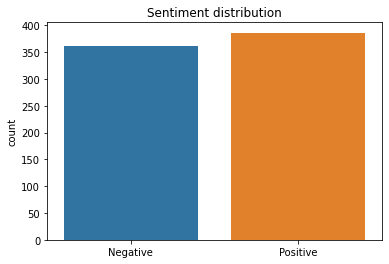

In [10]:
Sentiment_visual = sns.countplot(x='Sentiment', data=imdb_data)
Sentiment_visual.set_title("Sentiment distribution")
Sentiment_visual.set_xticklabels(['Negative', 'Positive'])
plt.xlabel("");

Splitting data into test dataset and train dataset and development dataset

In [51]:
imdb_train, imdb_test = train_test_split(imdb_data,test_size=0.2,shuffle=True)
imdb_train, imdb_dev = train_test_split(imdb_train,test_size=0.30,shuffle=True)

Lets see how the data distribution looks like in training data set

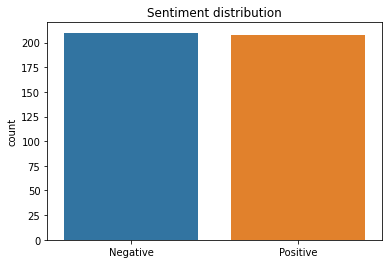

In [52]:
Sentiment_visual = sns.countplot(x='Sentiment', data=imdb_train)
Sentiment_visual.set_title("Sentiment distribution")
Sentiment_visual.set_xticklabels(['Negative', 'Positive'])
plt.xlabel("");

What are the most common words?

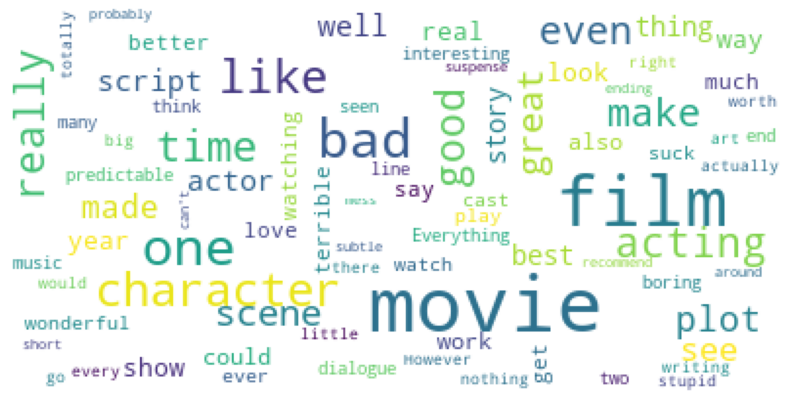

In [53]:
text = " ".join(Review for Review in imdb_train.Review)


wordcloud = WordCloud(max_font_size=40, max_words=80, background_color="white", stopwords=stopwords.words("english")).generate(text)
plt.figure(figsize=[14,8])
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

In [35]:
class NBC:
    def __init__(self):
        self.vocab = {}
        self.prior = {}
        self.likelihood_positive = {}
        self.likelihood_negative = {}
        
    def train(self, data, smoothing=0):
        
        positive_reviews = data.loc[data['Sentiment'] == 1]
        negative_reviews = data.loc[data['Sentiment'] == 0]
        

        total_positive_reviews = len(positive_reviews)
        total_negative_reviews = len(negative_reviews)
        count_review = len(data)
        
        
        self.prior['positive'] = total_positive_reviews / count_review
        self.prior['negative'] = total_negative_reviews / count_review
                        
        
        self.build_vocab(data)
        
        
        for word in self.vocab:
            count_positive_words = 0
            count_negative_words = 0
            total_positive = 0
            total_negative = 0
            for Review, Sentiment in zip(data['Review'], data['Sentiment']):
                if Sentiment == 1:
                    count_positive_words += Review.count(word)
                    total_positive += len(self.maketokens(Review))
                elif Sentiment == 0:
                    count_negative_words += Review.count(word)
                    total_negative += len(self.maketokens(Review))
                    
            
            self.likelihood_positive[word] = (count_positive_words + smoothing) / (total_positive + smoothing * len(self.vocab))        
            self.likelihood_negative[word] = (count_negative_words + smoothing) / (total_negative + smoothing * len(self.vocab))
    
    def predict(self, Reviews):
        result = []
        
        for Review in Reviews:
            ppositive = self.prior['positive']
            pnegative = self.prior['negative']
            
            for word in self.maketokens(Review):
                if word in self.vocab:
                    ppositive *= self.likelihood_positive[word]
                    pnegative *= self.likelihood_negative[word]
                    
            result.append(1 if ppositive > pnegative else 0)
        return result
    
    def build_vocab(self, data):
        for Review in data['Review']:
            for token in self.maketokens(Review):
                if token not in self.vocab:
                    self.vocab[token] = 1
                else:
                    self.vocab[token] += 1

    def maketokens(self, Review):
        clean_review = Review.translate(str.maketrans('', '', string.punctuation)).lower()
        return [word for word in clean_review.split() if word.isalpha()]
    
    def laplace_smoothing(self, word, text_class):
      num = self.word_counts[text_class][word] + 1
      denom = self.n_class_items[text_class] + len(self.vocab)
      return math.log(num / denom)

In [54]:
nbc = NBC()
nbc.train(imdb_train)
predictions = nbc.predict(imdb_dev['Review'])
accuracy = accuracy_score(predictions, imdb_dev['Sentiment'])
print(f'Accuracy of Naive Bayes is {accuracy*100.0:}%')

Accuracy of Naive Bayes is 64.44444444444444%


Five Folds cross vallidation

In [56]:
from sklearn.model_selection import RepeatedKFold
f=RepeatedKFold(n_splits=5, n_repeats=10, random_state=None)
kf_accuracy = []

nbc = NBC()

for train_index, test_index in f.split(imdb_train):
    trainfold = imdb_train.iloc[train_index]
    testfold = imdb_train.iloc[test_index]
    nbc.train(trainfold)
    predictions = nbc.predict(testfold['Review'])
    kf_accuracy.append(accuracy_score(predictions, testfold['Sentiment']))
    
kfold_average = np.mean(kf_accuracy)
print(f'5-fold cross-validation accuracy is {kfold_average * 100.0:.3f} %')

5-fold cross-validation accuracy is 53.249 %


Conditional Probability of 'The' given positive and Top 10 Positive and Negative words

In [43]:
import string
from string import punctuation, digits
stopword = stopwords.words('english') + []
all_counter = Counter()
negative_counter = Counter()
positive_counter = Counter()
negative_positive_ratio = Counter()
positive_negative_ratio = Counter()
tkn = Tokenizer()
for Review, Sentiment in imdb_train.values:
    words = [w for w in Review.translate(str.maketrans('', '', punctuation + digits)).lower().split() if w.isalpha()]
    for word in words:
        if word not in stopword:
            all_counter[word] += 1
            (positive_counter if Sentiment == 1 else negative_counter)[word] += 1

In [46]:
positive_reviews = len(imdb_train.loc[imdb_train['Sentiment'] == 1])
print(positive_reviews)
occ = 0
positive_occurences = 0

for Review, Sentiment in imdb_train.values:
    if 'the' in Review:
        occ += 1
        if Sentiment == 1:
            positive_occurences += 1
            
print(f'P[\'the\'] = {occ / len(imdb_train):}')
print(f'P[\'the\' | Positive] = {positive_occurences / positive_reviews:}')

for word, _ in all_counter.most_common():
    rat = float(positive_counter[word]) / float(negative_counter[word] + 1.0)
    positive_negative_ratio[word] = rat
    rat1 = float(negative_counter[word]) / float(positive_counter[word] + 1.0)
    negative_positive_ratio[word] = rat1
    
pos_words = positive_negative_ratio.most_common()[:10]
neg_words = negative_positive_ratio.most_common()[:10]
print("\n")
print('Top 10 positive words and their frequencies:')
print("\n")
print(*pos_words, sep = "\n")
print("\n")
print('Top 10 negative words and their frequencies:')
print("\n")
print(*neg_words, sep= "\n")


204
P['the'] = 0.5257731958762887
P['the' | Positive] = 0.553921568627451


Top 10 positive words and their frequencies:


('interesting', 8.0)
('sucks', 8.0)
('two', 5.0)
('wonderful', 4.5)
('right', 4.0)
('hilarious', 4.0)
('comedy', 4.0)
('music', 3.5)
('giallo', 3.0)
('appreciate', 3.0)


Top 10 negative words and their frequencies:


('awful', 9.0)
('nothing', 8.0)
('im', 7.0)
('didnt', 6.5)
('bad', 6.2)
('would', 6.0)
('worst', 6.0)
('whatever', 6.0)
('annoying', 5.0)
('sucked', 5.0)


Effect of smoothing

In [49]:
nbc = NBC()
nbc.train(imdb_train, smoothing=2)
predictions = nbc.predict(imdb_test['Review'])
acc = accuracy_score(predictions, imdb_test['Sentiment'])
print(f'Accuracy of Naive Bayes with smoothing is {acc*100.0:}%')

Accuracy of Naive Bayes with smoothing is 72.0%


Improved NBC

In [94]:
class MultinomialNaiveBayes:
  
    def __init__(self, classes, tokenizer):
      self.tokenizer = tokenizer
      self.classes = classes
      
    def group_by_class(self, X, y):
      data = dict()
      for c in self.classes:
        data[c] = X[np.where(y == c)]
      return data
           
    def fit(self, X, y):
        self.n_class_items = {}
        self.log_class_priors = {}
        self.word_counts = {}
        self.vocab = set()

        n = len(X)
        
        grouped_data = self.group_by_class(X, y)
        
        for c, data in grouped_data.items():
          self.n_class_items[c] = len(data)
          self.log_class_priors[c] = math.log(self.n_class_items[c] / n)
          self.word_counts[c] = defaultdict(lambda: 0)
          
          for text in data:
            counts = Counter(self.tokenizer.tokenize(text))
            for word, count in counts.items():
                if word not in self.vocab:
                    self.vocab.add(word)

                self.word_counts[c][word] += count
                
        return self
      
    def laplace_smoothing(self, word, text_class):
      num = self.word_counts[text_class][word] + 1
      denom = self.n_class_items[text_class] + len(self.vocab)
      return math.log(num / denom)
      
    def predict(self, X):
        result = []
        for text in X:
          
          class_scores = {c: self.log_class_priors[c] for c in self.classes}

          words = set(self.tokenizer.tokenize(text))
          for word in words:
              if word not in self.vocab: continue

              for c in self.classes:
                
                log_w_given_c = self.laplace_smoothing(word, c)
                class_scores[c] += log_w_given_c
                
          result.append(max(class_scores, key=class_scores.get))

        return result

In [101]:
X = imdb_train['Review'].values
y = imdb_train['Sentiment'].values
  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [102]:
MNB = MultinomialNaiveBayes(
    classes=np.unique(y), 
    tokenizer=Tokenizer()
).fit(X_train, y_train)

In [103]:
y_hat = MNB.predict(X_test)

In [106]:
acc1 = accuracy_score(y_test, y_hat)
acc1

0.7301587301587301

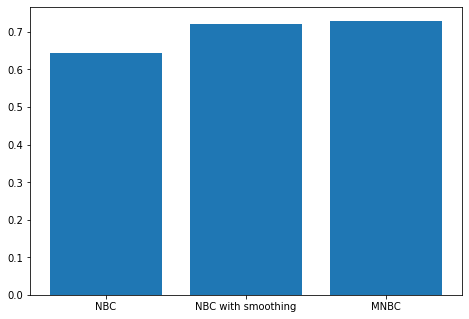

In [109]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
accuracies = [accuracy, acc, acc1]
NBCs = ['NBC','NBC with smoothing','MNBC']
ax.bar(NBCs,accuracies)
plt.show()

References:
1. https://levelup.gitconnected.com/movie-review-sentiment-analysis-with-naive-bayes-machine-learning-from-scratch-part-v-7bb869391bab
2. https://www.analyticsvidhya.com/blog/2018/05/improve-model-performance-cross-validation-in-python-r/
3. https://www.kaggle.com/lakshmi25npathi/sentiment-analysis-of-imdb-movie-reviews
4. https://medium.com/@kcatstack/sentiment-analysis-naive-bayes-classifier-from-scratch-part-1-theory-4949115ba13
5. https://machinelearningmastery.com/naive-bayes-classifier-scratch-python/
6. https://colab.research.google.com/notebooks/io.ipynb
7. https://www.crummy.com/software/BeautifulSoup/bs4/doc/
8. https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
9. https://predictivehacks.com/how-to-get-a-sentiment-score-for-words-in-python/